In [1]:
!pip install matplotlib


[notice] A new release of pip is available: 23.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip



  Obtaining dependency information for matplotlib from https://files.pythonhosted.org/packages/4d/9c/65830d4a56c47f5283eaa244dc1228c5da9c844a9f999ebcc2e69bf6cc65/matplotlib-3.7.2-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for contourpy>=1.0.1 from https://files.pythonhosted.org/packages/16/09/989b982322439faa4bafffcd669e6f942b38fee897c2664c987bcd091dec/contourpy-1.1.0-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for fonttools>=4.22.0 from https://files.pythonhosted.org/packages/52/65/aaa3d2b7a292d93cc2cf1c534d03ba3f744e480f15b3b2ab6ad68189f7ee/fonttools-4.42.0-cp311-cp311-win_amd64.whl.metadata
     ---------------------------------------- 0.0/153.7 kB ? eta -:--:--
     -------------------------------------- 153.7/153.7 kB 4.6 MB/s eta 0:00:00
     ---------------------------------------- 0.0/55.4 kB ? eta -:--:--
     ---------------------------------------- 55.4/55.4 kB ? eta 0:00:00
     ---------------------------------------- 0

In [2]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()


print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.12.0


In [3]:
train = pd.read_csv('dataset/train.txt',sep = ";")
test = pd.read_csv('dataset/test.txt',sep = ";")
val = pd.read_csv('dataset/val.txt',sep = ";")

In [4]:
train

,text,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger
...,...,...
15995,i just had a very brief time in the beanbag an...,sadness
15996,i am now turning and i feel pathetic that i am...,sadness
15997,i feel strong and good overall,joy
15998,i feel like this was such a rude comment and i...,anger


In [5]:
def get_tweet(data):
  tweets = list(data['text'])
  labels = list(data['label'])

  return tweets,labels

In [6]:
tweets, labels = get_tweet(train)

In [7]:
tweets[0],labels[0]

('i didnt feel humiliated', 'sadness')

In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [9]:
tokenizer = Tokenizer(num_words = 1000 , oov_token = '<UNK>')
tokenizer.fit_on_texts(tweets)

In [10]:
tokenizer.texts_to_sequences([tweets[0]])

[[2, 139, 3, 679]]

In [11]:
lengths = [len(t.split(' ')) for t in tweets]

(array([2641., 3795., 3968., 2306., 1499.,  963.,  453.,  251.,  106.,
          18.]),
 array([ 2. ,  8.4, 14.8, 21.2, 27.6, 34. , 40.4, 46.8, 53.2, 59.6, 66. ]),
 <BarContainer object of 10 artists>)

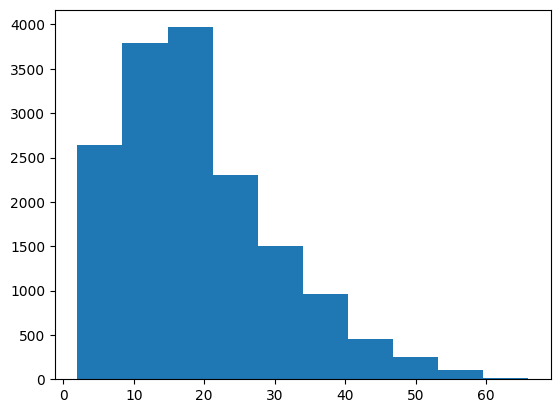

In [12]:
plt.hist(lengths)

In [13]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [14]:
def get_sequences(tokenizer,tweets):
  sequences = tokenizer.texts_to_sequences(tweets)
  padded = pad_sequences(sequences, truncating = 'post', padding = 'post' , maxlen = 60)
  return padded

In [15]:
padded_train_seq = get_sequences(tokenizer,tweets)
padded_train_seq[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0])

In [16]:
classes = set(labels)

In [36]:
classes_index = dict((label,i) for label,i in enumerate(classes))
index_classes = dict((i,label) for label,i in enumerate(classes))

In [18]:
classes_index

{0: 'fear', 1: 'surprise', 2: 'anger', 3: 'joy', 4: 'sadness', 5: 'love'}

In [37]:
text_to_label = lambda labels : np.array([index_classes.get(x) for x in labels])

In [38]:
train_labels = text_to_label(labels)

In [39]:
train_labels[0]

4

In [40]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.Embedding(10000,16,input_length = 60),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20,return_sequences =  True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
        tf.keras.layers.Dense(6,activation = 'softmax')
    ]
)

In [41]:
model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [42]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 60, 16)            160000    
                                                                 
 bidirectional_2 (Bidirectio  (None, 60, 40)           5920      
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 6)                 246       
                                                                 
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


In [43]:
val_tweets , val_labels = get_tweet(val)
val_seq = get_sequences(tokenizer,val_tweets)
val_labels = text_to_label(val_labels)

In [44]:
classes_index

{0: 'fear', 1: 'surprise', 2: 'anger', 3: 'joy', 4: 'sadness', 5: 'love'}

In [45]:
(val_tweets[15:20],val_labels[15:20])

(['i never stop feeling thankful as to compare with others i considered myself lucky because i did not encounter ruthless pirates and i did not have to witness the slaughter of others',
  'i didn t feel abused and quite honestly it made my day a little better',
  'i know what it feels like he stressed glaring down at her as she squeezed more soap onto her sponge',
  'i also loved that you could really feel the desperation in these sequences and i especially liked the emotion between knight and squire as theyve been together in a similar fashion to batman and robin for a long time now',
  'i had lunch with an old friend and it was nice but in general im not feeling energetic'],
 array([3, 4, 2, 5, 3]))

In [46]:
history = model.fit(
    padded_train_seq,train_labels,
    validation_data = (val_seq,val_labels),
    epochs = 20,
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 2)])

Epoch 1/20
500/500 [==============================] - 17s 21ms/step - loss: 1.3133 - accuracy: 0.4768 - val_loss: 0.8322 - val_accuracy: 0.6910
Epoch 2/20
500/500 [==============================] - 9s 18ms/step - loss: 0.6946 - accuracy: 0.7533 - val_loss: 0.6523 - val_accuracy: 0.7750
Epoch 3/20
500/500 [==============================] - 8s 16ms/step - loss: 0.5016 - accuracy: 0.8296 - val_loss: 0.4685 - val_accuracy: 0.8455
Epoch 4/20
500/500 [==============================] - 9s 17ms/step - loss: 0.4133 - accuracy: 0.8591 - val_loss: 0.4545 - val_accuracy: 0.8495
Epoch 5/20
500/500 [==============================] - 9s 17ms/step - loss: 0.3595 - accuracy: 0.8707 - val_loss: 0.4188 - val_accuracy: 0.8535
Epoch 6/20
500/500 [==============================] - 8s 17ms/step - loss: 0.3361 - accuracy: 0.8771 - val_loss: 0.4086 - val_accuracy: 0.8540
Epoch 7/20
500/500 [==============================] - 8s 16ms/step - loss: 0.3186 - accuracy: 0.8848 - val_loss: 0.4394 - val_accuracy: 0.858

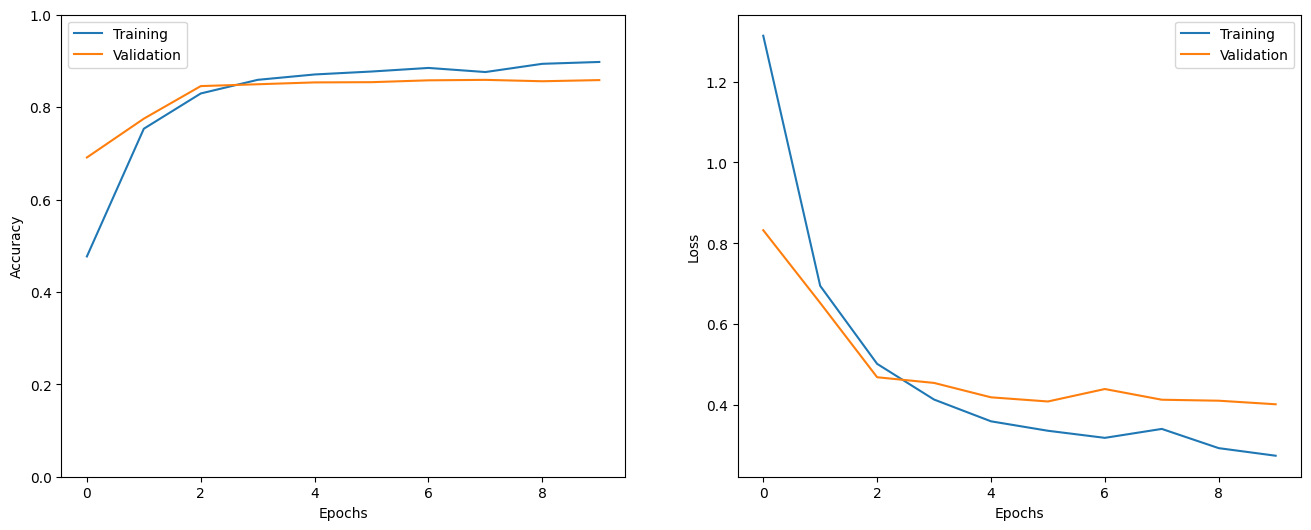

In [47]:
show_history(history)

In [48]:
test_tweets,test_labels = get_tweet(test)
test_seq = get_sequences(tokenizer, test_tweets)
test_labels = text_to_label(test_labels)

In [58]:
i = random.randint(0,len(test_labels) - 1)
print('Sentence: ',test_tweets[i])
print("Actual: ",classes_index[test_labels[i]])

prediction = model.predict(np.expand_dims(test_seq[i],axis=0))[0]
predicted = np.argmax(prediction)
print("Predicted",classes_index[predicted])

Sentence:  i also feel this conversation could dovetail quite easily into another about images and objects that are ugly to serve the purpose of being ironic
Actual:  sadness
1/1 [==============================] - 0s 22ms/step
Predicted sadness


In [53]:
model.save('emotion.h5')